In [1]:
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader

logging.basicConfig(level="INFO")
logger = logging.getLogger(__name__)

root_dir_path = Path("./data/Profile_Ear")

# profile and ear
profile_dir_path = root_dir_path / "Profile"
ear_dir_path = root_dir_path / "Ear"

# profile and ear directory path
profile_label_path = root_dir_path / "Profile_Label.csv"
ear_label_path = root_dir_path / "Ear_Label.csv"

In [23]:
# define device
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

logger.info(device)

INFO:__main__:mps


## Prepare dataset

INFO:__main__:60, 60


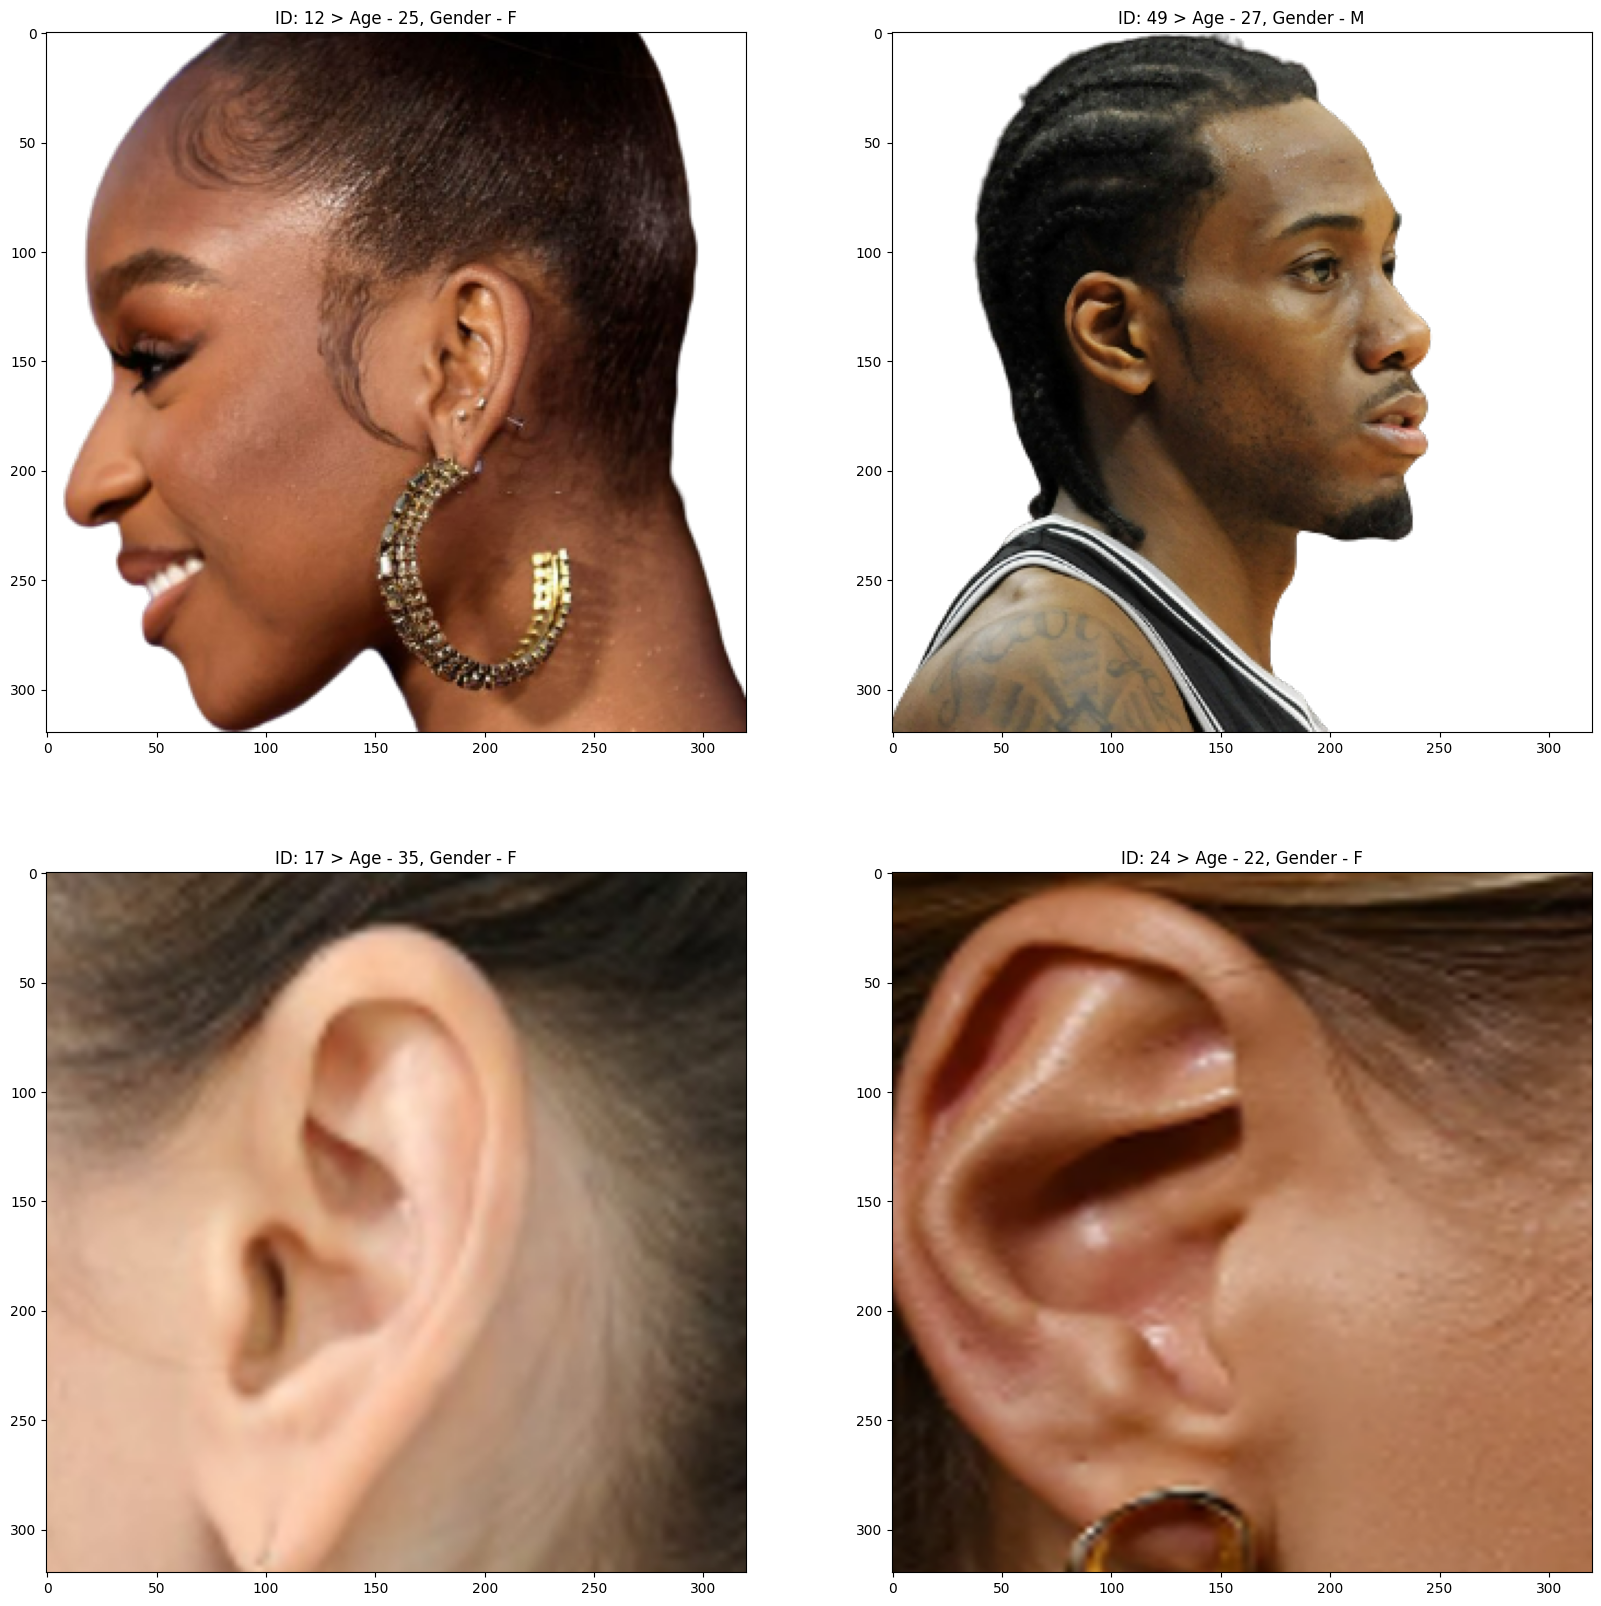

In [3]:
# read profile and ear data
ear_labels = pd.read_csv(ear_label_path)
profile_labels = pd.read_csv(profile_label_path)
logger.info(f"{len(ear_labels)}, {len(profile_labels)}")

# show sample images
sample_ear_labels = ear_labels.sample(2).reset_index(drop=True)
sample_profile_labels = profile_labels.sample(2).reset_index(drop=True)

fig, axs = plt.subplots(2, 2, figsize=(20, 20))

for idx, row in sample_profile_labels.iterrows():
    _profile_img_path = os.path.join(profile_dir_path, f"{row['ProfileID']}.png")
    _profile_image = Image.open(_profile_img_path)
    axs[0, idx].imshow(_profile_image)
    axs[0, idx].set_title(f"ID: {row['ProfileID']} > Age - {row['Age']}, Gender - {row['Gender']}")
    
for idx, row in sample_ear_labels.iterrows():
    _ear_image_path = os.path.join(ear_dir_path, f"{row['EarID']}.png")
    _ear_image = Image.open(_ear_image_path)
    axs[1, idx].imshow(_ear_image)
    axs[1, idx].set_title(f"ID: {row['EarID']} > Age - {row['Age']}, Gender - {row['Gender']}")

In [4]:
profile_age_labels = profile_labels['Age'].to_numpy()
profile_gender_labels = profile_labels['Gender'].to_numpy()
ear_age_labels = ear_labels['Age'].to_numpy()
ear_gender_labels = ear_labels['Gender'].to_numpy()

profile_gender_labels = np.array([0 if x == 'F' else 1 for x in profile_gender_labels])
ear_gender_labels = np.array([0 if x == 'F' else 1 for x in ear_gender_labels])

# convert numpy arrays to tensors
profile_age_labels = torch.from_numpy(profile_age_labels).float()
profile_gender_labels = torch.from_numpy(profile_gender_labels).float()
ear_age_labels = torch.from_numpy(ear_age_labels).float()
ear_gender_labels = torch.from_numpy(ear_gender_labels).float()

In [5]:
# prepare profile images
profile_images = []
for i in range(1, len(profile_labels)+1):
    img_path = os.path.join(profile_dir_path, f"{i}.png")
    profile_img = Image.open(img_path)
    profile_img = profile_img.resize((320, 320))
    # convert to gray scale
    profile_img = profile_img.convert('L')
    profile_img = np.array(profile_img)
    # add batch dimension
    profile_img = np.expand_dims(profile_img, axis=0)
    profile_images += [profile_img]

# prepare ear images
ear_images = []
for i in range(1, len(ear_labels)+1):
    img_path = os.path.join(ear_dir_path, f"{i}.png")
    ear_img = Image.open(img_path)
    ear_img = ear_img.resize((320, 320))
    # convert to gray scale
    ear_img = ear_img.convert('L')
    ear_img = np.array(ear_img)
    # add batch dimension
    ear_img = np.expand_dims(ear_img, axis=0)
    ear_images += [ear_img]

profile_images = np.concatenate(profile_images, axis=0)
profile_images = torch.from_numpy(profile_images).float()
ear_images = np.concatenate(ear_images, axis=0)
ear_images = torch.from_numpy(ear_images).float()

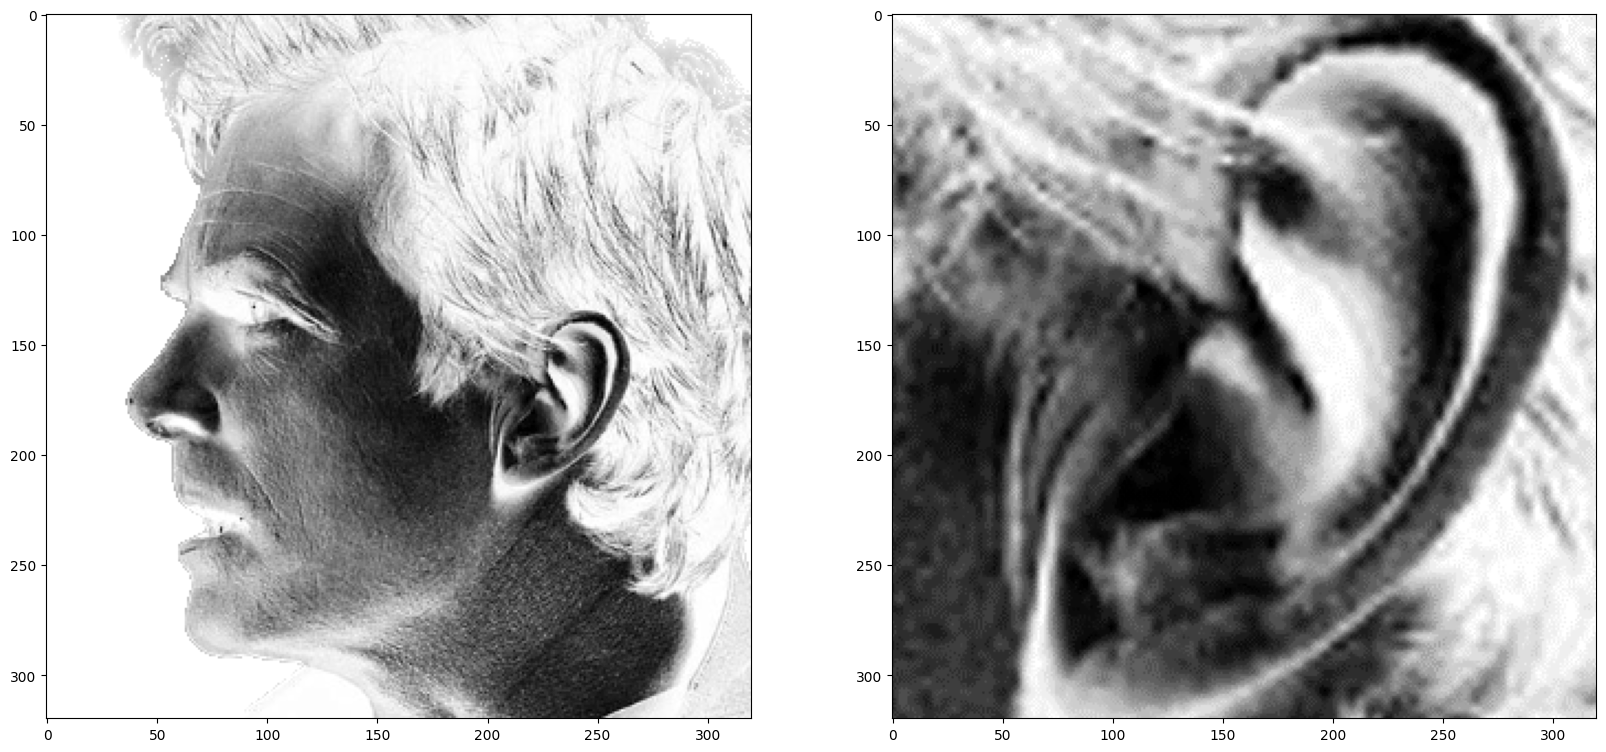

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(20, 20))
axs[0].imshow(profile_images[0], cmap='gray_r')
axs[1].imshow(ear_images[0], cmap='gray_r')

In [7]:
from sklearn.model_selection import train_test_split

(
    profile_images_train, 
    profile_images_val,
    profile_age_labels_train,
    profile_age_labels_val,
    profile_gender_labels_train,
    profile_gender_labels_val
) = train_test_split(
    profile_images,
    profile_age_labels,
    profile_gender_labels,
    test_size=.2,
    random_state=42
)

(
    ear_images_train, 
    ear_images_val,
    ear_age_labels_train,
    ear_age_labels_val,
    ear_gender_labels_train,
    ear_gender_labels_val
) = train_test_split(
    ear_images,
    ear_age_labels,
    ear_gender_labels,
    test_size=.2,
    random_state=42
)

## UniModal Training for age prediction

In [8]:
class SimpleDataset(Dataset):
    
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

class SimpleAgeModel(nn.Module):
    
    def __init__(self):
        super(SimpleAgeModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=512*20*20, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=1)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
model = SimpleAgeModel()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=.001)
crit = nn.MSELoss() # reduction default: 'mean'

train_dataset = SimpleDataset(profile_images_train, profile_age_labels_train)
val_dataset = SimpleDataset(profile_images_val, profile_age_labels_val)

train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16, shuffle=False)

# train model
num_epochs = 10

for epoch in range(num_epochs):
    # train the model
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        # |images| = (bs, width, height); |labels| = (bs, )
        # load data to device
        
        # Note. you don't have to manually unload data from the gpu at the end of
        # every epoch. Pytorch automatically manages memory using reference counting and
        # garbage collection. After every epoch, the memory occupied by tensors that are
        # no longer referenced is freed.
        
        # However, you can manually free it as below:
        # Example:
        #   .. code-block: python
        #   del images, labels
        #   torch.cuda.empty_cache()
        
        images, labels = (
            images.unsqueeze(1).float().to(device),
            labels.unsqueeze(1).float().to(device)
        )
        # clear gradients after every step or epoch
        optimizer.zero_grad()
        outputs = model(images)
        # |outputs| = (bs, 1)
        loss = crit(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss /= len(train_loader.dataset)
    
    # evaluate the model
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = (
                images.unsqueeze(1).float().to(device),
                labels.unsqueeze(1).float().to(device)
            )
            outputs = model(images)
            loss = crit(outputs, labels)
            val_loss += loss.item() * images.size(0)
    val_loss /= len(val_loader.dataset)
    
    # Print the training and validation loss
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Epoch 1/10, Training Loss: 9529805.8177, Validation Loss: 4127.7119
Epoch 2/10, Training Loss: 2646.1076, Validation Loss: 1818.0017
Epoch 3/10, Training Loss: 1552.7246, Validation Loss: 262.1880
Epoch 4/10, Training Loss: 962.4365, Validation Loss: 570.4156
Epoch 5/10, Training Loss: 725.7198, Validation Loss: 703.9919
Epoch 6/10, Training Loss: 443.4504, Validation Loss: 218.7349
Epoch 7/10, Training Loss: 409.8605, Validation Loss: 179.0234
Epoch 8/10, Training Loss: 260.6002, Validation Loss: 212.6424
Epoch 9/10, Training Loss: 251.4356, Validation Loss: 187.5532
Epoch 10/10, Training Loss: 221.3495, Validation Loss: 234.5431


## MultiModal training for age, gender prediction
- MultiTask
- Join or fusion, alignment comes in way.

In [24]:
class MultiModalDataset(Dataset):
    def __init__(
        self,
        images_profiles,
        images_ears,
        labels_age,
        labels_gender
    ):
        self.images_profiles = images_profiles
        self.images_ears = images_ears
        self.labels_age = labels_age
        self.labels_gender = labels_gender
    
    def __getitem__(self, idx):
        image_profile = self.images_profiles[idx]
        image_ear = self.images_ears[idx]
        label_age = self.labels_age[idx]
        label_gender = self.labels_gender[idx]
        return image_profile, image_ear, label_age, label_gender
    
    def __len__(self):
        return len(self.images_profiles)
    
class MultiModalModel(nn.Module):
    def __init__(self):
        super().__init__()
        # initialize profile model
        self.profile_model = models.resnet50(weights='ResNet50_Weights.DEFAULT')
        # replace the first convolution network
        self.profile_model.conv1 = nn.Conv2d(
            1, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.profile_model.fc = nn.Identity()
        
        # initialize ear model
        self.ear_model = models.resnet50(weights='ResNet50_Weights.DEFAULT')
        self.ear_model.conv1 = nn.Conv2d(
            1, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.ear_model.fc = nn.Identity()
        
        # additional gender layers
        self.sigmoid = nn.Sigmoid()
        self.common_linear = nn.Linear(4096, 256)
        self.gender_output = nn.Linear(256, 1)
        
        # additional age layers
        self.age_linear = nn.Linear(256, 100)
        self.age_output = nn.Linear(100, 1)
        
    def forward(self, input_profile, input_ear):
        # |input_profile| = (bs, 1, 320, 320)
        # |input_ear| = (bs, 1, 320, 320)
        x_profile = self.profile_model(input_profile)
        x_ear = self.ear_model(input_ear)
        # |x_profile| = (bs, 2048); |x_ear| = (bs, 2048)
        
        concat_output = torch.cat(
            (x_profile.view(x_profile.size(0), -1), x_ear.view(x_ear.size(0), -1)),
            dim=1
        )
        # |concat_output| = (bs, 4096)
        
        # predict gender
        gender_output = self.sigmoid(self.gender_output(self.common_linear(concat_output)))
        
        # predict age
        age_output = self.common_linear(concat_output)
        age_output = self.age_output(self.age_linear(age_output.view(age_output.size(0), -1)))
        return gender_output, age_output

# Initialize the model and optimizer
model = MultiModalModel()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the loss function
age_crit = nn.MSELoss()
gender_crit = nn.BCELoss()

# Create the custom datasets
train_dataset = MultiModalDataset(profile_images_train, ear_images_train, profile_age_labels_train, profile_gender_labels_train)
val_dataset = MultiModalDataset(profile_images_val, ear_images_val, profile_age_labels_val, profile_gender_labels_val)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Train the model
num_epochs = 10

for epoch in range(num_epochs):
    # Train the model on the training set
    model.train()
    train_loss = 0
    for images_profiles, images_ears, labels_age, labels_gender in train_loader:
        images_profiles, images_ears, labels_age, labels_gender = (
            images_profiles.unsqueeze(1).float().to(device),
            images_ears.unsqueeze(1).float().to(device),
            labels_age.unsqueeze(1).float().to(device),
            labels_gender.unsqueeze(1).float().to(device)
        )   
        optimizer.zero_grad()
        output_gender, output_age = model(images_profiles, images_ears)
        loss_age = age_crit(output_age, labels_age)
        loss_gender = gender_crit(output_gender, labels_gender)
        loss = loss_age + loss_gender
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images_profiles.size(0)
    train_loss /= len(train_loader.dataset)
    
    # Evaluate the model on the validation set
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images_profiles, images_ears, labels_age, labels_gender in val_loader:
            images_profiles, images_ears, labels_age, labels_gender = (
                images_profiles.unsqueeze(1).float().to(device),
                images_ears.unsqueeze(1).float().to(device),
                labels_age.unsqueeze(1).float().to(device),
                labels_age.unsqueeze(1).float().to(device)
            )  
            output_gender, output_age = output_gender, output_age = model(images_profiles, images_ears)
            loss_age = age_crit(output_age, labels_age)
            loss_gender = gender_crit(output_gender, labels_gender)
            loss = loss_age + loss_gender
            val_loss += loss.item() * images_profiles.size(0)
    val_loss /= len(val_loader.dataset)
    
    # Print the training and validation loss
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Epoch 1/10, Training Loss: 1461.4250, Validation Loss: 870.0553
Epoch 2/10, Training Loss: 474.3340, Validation Loss: 484.6991
Epoch 3/10, Training Loss: 340.3269, Validation Loss: 448.1092
Epoch 4/10, Training Loss: 310.1449, Validation Loss: 408.7556
Epoch 5/10, Training Loss: 212.8069, Validation Loss: 769.9991
Epoch 6/10, Training Loss: 97.7681, Validation Loss: 323.9308
Epoch 7/10, Training Loss: 125.3411, Validation Loss: 309.9300
Epoch 8/10, Training Loss: 85.7622, Validation Loss: 382.6345
Epoch 9/10, Training Loss: 72.0768, Validation Loss: 393.0531
Epoch 10/10, Training Loss: 22.6636, Validation Loss: 280.1231


In [5]:
import torchvision.models as models

vgg16 = models.vgg16()
resnet50 = models.resnet50()

# ====== Age Model ===== #

# modify the last classification layer
logger.info(vgg16.classifier[-1])
vgg16.classifier[-1] = nn.Linear(4096, 256, bias=True)

# initialize the age model
age_model = nn.Sequential(
    vgg16,
    nn.ReLU(),
    nn.Dropout(p=.5, inplace=False),
    nn.Linear(256, 1)
)

# register the model to the appropriate device
age_model.to(device)
print(next(age_model.parameters()).device)

# set optimizer and criterion (loss function)
optimizer = torch.optim.Adam(
    age_model.parameters(), 
    lr=.001
)
crit = nn.MSELoss()

# ====== Gender Model ===== #

# modify the last fc layer
resnet50.fc = nn.Linear(2048, 256, bias=True)
gender_model = nn.Sequential(
    resnet50,
    nn.ReLU(),
    nn.Dropout(p=.5),
    nn.Linear(256, 1),
    nn.Sigmoid()
)
# register the model to the appropriate device
gender_model.to(device)
print(next(gender_model.parameters()).device)

# set optimizer and criterion (loss function)
optimizer = torch.optim.Adam(
    gender_model.parameters(), 
    lr=.001
)
crit = nn.BCELoss()

60